# clustering with visualisation

In [1]:
import matplotlib
matplotlib.__version__

'3.5.2'

In [2]:
%matplotlib inline

In [3]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pathlib
from collections import Counter
from pandas_profiling import ProfileReport
pd.set_option('display.max_columns', None)

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import completeness_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

import yellowbrick
import yellowbrick.datasets
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# overview of clustering process

Overview
1. Choose features - important to identifying and understanding differences
2. Scale the data
3. Screen for outliers
4. Calculate distances
5. Select clustering algorithm
6. Obtain one or more clusters
7. Determine number of clusters present
8. Obtain final clustering solution
9. Visualise results
10. Interpret clusters
11. Validate results

### Explore data

In [5]:
# source data: http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [6]:
credit_df = pd.read_csv('./default of credit card clients.csv')
credit_df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [7]:
credit_df = credit_df.drop(['ID', 'default payment next month'],axis=1)

### Scale Data

In [8]:
scaler = StandardScaler()
credit_df = pd.DataFrame(scaler.fit_transform(credit_df), columns=credit_df.columns)

In [9]:
credit_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,0.810161,0.185828,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,0.810161,0.185828,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.597202,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.905498,0.810161,0.185828,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.905498,-1.234323,0.185828,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187


### Elbow method - determine number of clusters

In [10]:
@interact
def CreditElbow(Method=['distortion', 'silhouette']):
    plt.figure(figsize=(10, 8))
    model = KMeans(Method)
    visualizer = KElbowVisualizer(model, k=(2,12), metric=Method, locate_elbow=True)
    visualizer.fit(credit_df)

interactive(children=(Dropdown(description='Method', options=('distortion', 'silhouette'), value='distortion')…

In [11]:
@interact
def Elbow(Clusters=(2,10)):
    plt.figure(figsize=(10, 8))
    model = KMeans(Clusters)
    visualizer = SilhouetteVisualizer(model, colors='plasma')
    visualizer.fit(credit_df)

interactive(children=(IntSlider(value=6, description='Clusters', max=10, min=2), Output()), _dom_classes=('wid…

### intercluster distance map

In [12]:
@interact
def Interdistance(Clusters=(2,10)):
    plt.figure(figsize=(10, 8))
    model = KMeans(Clusters)
    visualizer = InterclusterDistance(model, colors='plasma')
    visualizer.fit(credit_df)

interactive(children=(IntSlider(value=6, description='Clusters', max=10, min=2), Output()), _dom_classes=('wid…

### kmeans

In [13]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(credit_df)

### visualise with PCA

Text(0.5, 1.0, 'First 2 Principal Components - Credit (46.3% Variance Explained)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


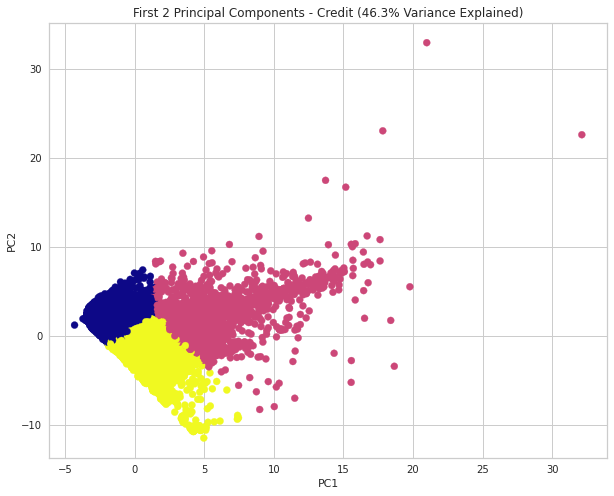

In [14]:
pca2d = PCA(n_components=2)
pcs = pd.DataFrame(pca2d.fit_transform(credit_df))
plotDF = pd.DataFrame(columns=['PC1', 'PC2', 'Cluster'])
plotDF['PC1'] = pcs[0]
plotDF['PC2'] = pcs[1]
plotDF['Cluster'] = clusters

plt.figure(figsize=(10,8))
plt.scatter(x=plotDF.PC1, y=plotDF.PC2, c=plotDF.Cluster, cmap='plasma')
plt.xlabel('PC1')
plt.ylabel('PC2')
percent_explained = sum(pca2d.explained_variance_ratio_) * 100.
plt.title('First 2 Principal Components - Credit ({:.1f}% Variance Explained)'.format(percent_explained))